In [32]:
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import torch
from diffusers.utils import make_image_grid

from slideredit.pipelines import SliderEditFluxKontextPipeline
from evaluation import (
    CLIPEvaluator,
    SiglipEvaluator,
    BLIPEvaluator,
    LPIPSFeatureDistanceEvaluator,
    DiNOFeatureDistanceEvaluator,
    FaceIdentityDistanceEvaluator,
)
from evaluation.utils import normalize_to_unit_interval, chi_square_1d

## 1) Loading SliderEdit Pipeline and Generate Images

In [3]:
pipe = SliderEditFluxKontextPipeline.from_pretrained("black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16).to("cuda")
pipe.load_gstlora("../checkpoints/example_training_gstlora_iter500.safetensors")
clear_output()
print("Pipeline with GSTLoRA loaded successfully!")

Pipeline with GSTLoRA loaded successfully!


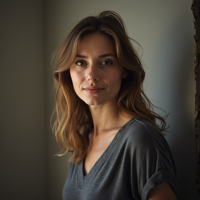

Edit prompt: make the hair of the person curly


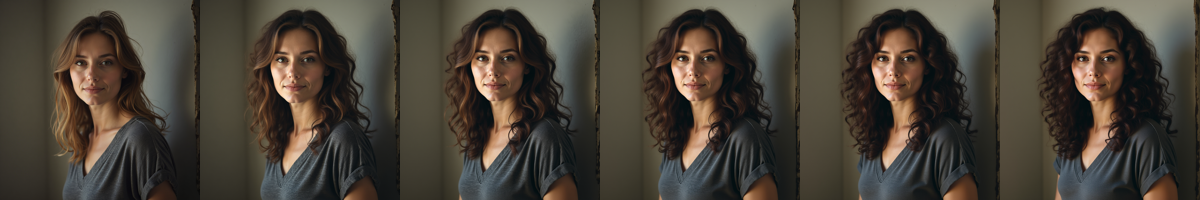

In [4]:
img = Image.open("../datasets/slideredit_faces_dataset/woman_7.png")
edit_prompt = "make the hair of the person curly"
alpha_values = [1, 0.8, 0.5, 0, -0.5, -1]

outputs = []
for alpha in alpha_values:
    output_image = pipe(
        image=img,  
        prompt=edit_prompt,
        generator=torch.Generator().manual_seed(0),
        slider_alpha=alpha,
    ).images[0]
    outputs.append(output_image)

clear_output()
display(img.resize((200, 200)))
print(f"Edit prompt: {edit_prompt}")
make_image_grid([x.resize((200, 200)) for x in outputs], rows=1, cols=len(outputs))

## 2) Evaluating the Generated Images

In [23]:
vlm_evaluators = {
    "CLIP": CLIPEvaluator(),
    "Siglip": SiglipEvaluator(),
    "BLIP": BLIPEvaluator(),
}
feature_distance_evaluators = {
    "LPIPS_vgg": LPIPSFeatureDistanceEvaluator(net="vgg"),
    "LPIPS_alex": LPIPSFeatureDistanceEvaluator(net="alex"),
    "DiNOv2": DiNOFeatureDistanceEvaluator(),
    "FaceID": FaceIdentityDistanceEvaluator(),
}
clear_output()
print("Evaluators loaded successfully!")

Evaluators loaded successfully!


In [27]:
prompt_to_use_for_vlm = "curly hair"

vlm_evaluator_res = {name: [] for name in vlm_evaluators.keys()}
feature_distance_evaluator_res = {name: [] for name in feature_distance_evaluators.keys()}
for output_image in tqdm(outputs):
    for name, evaluator in vlm_evaluators.items():
        score = evaluator.get_score(output_image, prompt_to_use_for_vlm)
        vlm_evaluator_res[name].append(score)
    for name, evaluator in feature_distance_evaluators.items():
        distance = evaluator.get_distance(img, output_image)
        feature_distance_evaluator_res[name].append(distance)

100%|██████████| 6/6 [01:10<00:00, 11.82s/it]


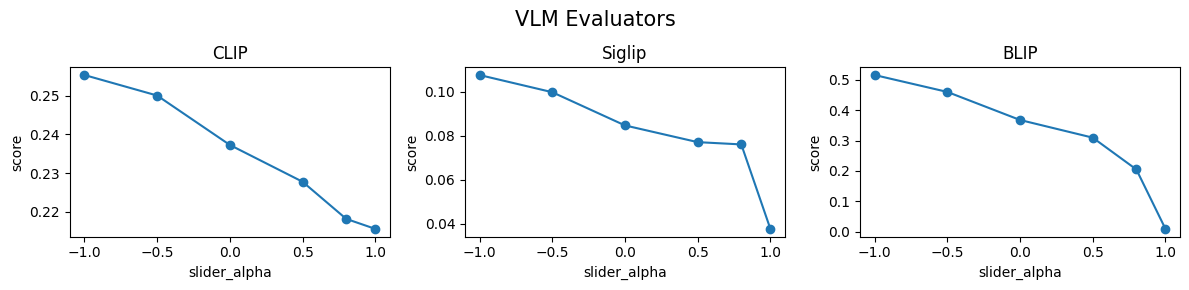

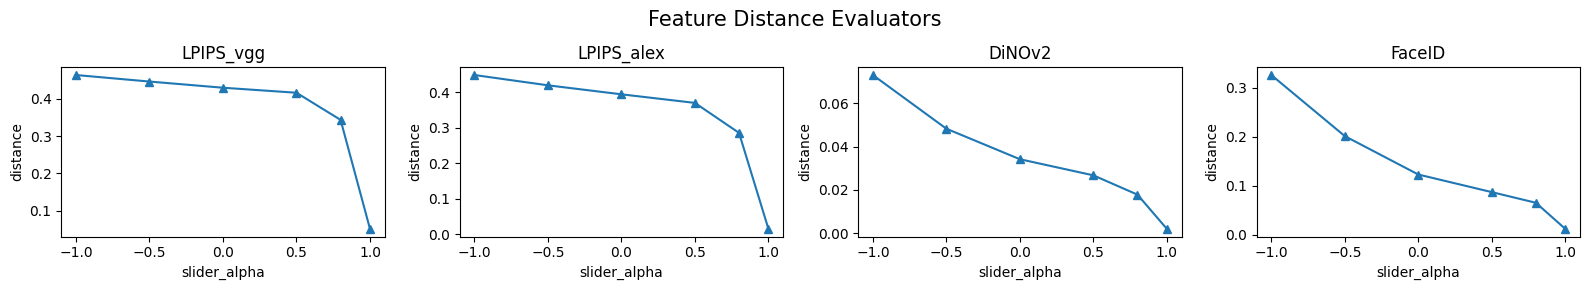

In [39]:
def plot_results(results_dict, alpha_values, title, ncols, ylabel, marker="o"):
    names = list(results_dict.keys())
    nrows = math.ceil(len(names) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), squeeze=False)
    for idx, name in enumerate(names):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]
        ax.plot(alpha_values, results_dict[name], marker=marker)
        ax.set_title(name)
        ax.set_xlabel("slider_alpha")
        ax.set_ylabel(ylabel)
    for idx in range(len(names), nrows * ncols):
        row, col = divmod(idx, ncols)
        axes[row][col].axis("off")
    fig.suptitle(title, fontsize=15, y=0.95)
    fig.tight_layout()

plot_results(vlm_evaluator_res, alpha_values, "VLM Evaluators", ncols=3, ylabel="score")
plot_results(feature_distance_evaluator_res, alpha_values, "Feature Distance Evaluators", ncols=4, ylabel="distance", marker="^")

In [ ]:
# Testing continuity of VLM scores across alpha values using chi-square uniformity test
print("Chi-square uniformity test results (lower is better here):")
for name, scores in vlm_evaluator_res.items():
    min_scores, max_scores = min(scores), max(scores)
    normalized_scores = normalize_to_unit_interval(np.array(scores), (min_scores, max_scores))
    stat, dof = chi_square_1d(normalized_scores, m=len(alpha_values))
    print(f"{name}: {(stat / dof).item()}")

Chi-square uniformity test results (lower is better here):
CLIP: 0.8
Siglip: 0.8
BLIP: 0.4
